<a href="https://colab.research.google.com/github/sheikh495/ComputerSystemsOrganization/blob/main/Copy_of_COSC_530_ProgrammingAssignment)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib


Trace file content:
flw    f6,32(x2):0
flw    f2,48(x3):4
fmul.s f0,f2,f4
fsub.s f8,f6,f2
fdiv.s f10,f0,f6
fadd.s f6,f8,f2


Configuration
-------------
buffers

eff addr: 2
fp adds: 3
fp muls: 3
ints: 2
reorder: 5

latencies

fp_add: 2
fp_sub: 2
fp_mul: 5
fp_div: 10


                 Pipeline Simulation
------------------------------------------------------------
                                        Memory Writes
------------------------------------------------------------
Instruction          Issues  Executes  Read    Result  Commits
--------------------- ------  --------- ------  ------  -------
flw    f6,32(x2)     1       -         -       1       1      
flw    f2,48(x3)     1       -         -       1       1      
fmul.s f0,f2,f4      1       1-2       3       1       1      
fsub.s f8,f6,f2      3       3-4       5       3       3      
fdiv.s f10,f0,f6     5       5-6       7       5       5      
fadd.s f6,f8,f2      7       7-8       9       7       7      

Delays
----

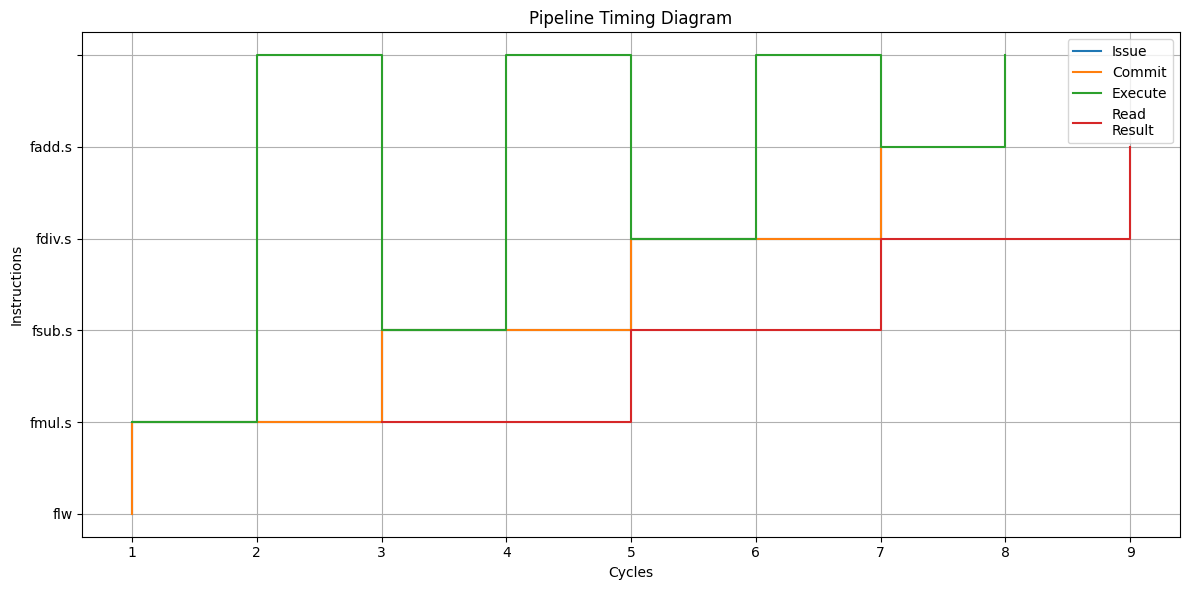

In [3]:


import matplotlib.pyplot as plt
# Step 1: Define the Instruction class to store information about each instruction.
class Instruction:
    def __init__(self, opcode, operands, address):
        self.opcode = opcode
        self.operands = operands
        self.address = address
        self.issue_cycle = None
        self.execute_start_cycle = None
        self.execute_end_cycle = None
        self.read_result_cycle = None
        self.commit_cycle = None

# Step 2: Define the Processor class to simulate the pipeline execution.
class Processor:
    def __init__(self, config_file):
        self.buffer_sizes = {}
        self.latencies = {}
        self.instructions = []
        self.reorder_buffer = []
        self.memory = {}
        self.load_buffer = []
        self.cycle = 1
        self.read_config(config_file)

    # Step 3: Read the pipeline configuration from the config_file.
    def read_config(self, config_file):
        with open(config_file, 'r') as file:
            config_lines = file.readlines()

        section = None
        for line in config_lines:
            line = line.strip()
            if line == "buffers":
                section = "buffers"
            elif line == "latencies":
                section = "latencies"
            elif section == "buffers" and line:
                name, value = line.split(':')
                self.buffer_sizes[name.strip()] = int(value)
            elif section == "latencies" and line:
                name, value = line.split(':')
                self.latencies[name.strip()] = int(value)

    # Step 4: Read the trace of RISC-V instructions to be executed.
    def read_trace(self, trace_file):
        with open(trace_file, 'r') as file:
            trace_lines = file.readlines()

        for line in trace_lines:
            opcode, operands = line.strip().split(' ', 1)
            if opcode in ['flw', 'lw', 'fsw', 'sw']:
                instr, address = operands.split(':')
                address = int(address)
            else:
                instr = operands
                address = None

            instruction = Instruction(opcode, instr, address)
            self.instructions.append(instruction)


    # Step 5: Execute an instruction and update the pipeline state accordingly.
    def execute_instruction(self, instruction):
        if instruction.opcode in ['flw', 'lw', 'fsw', 'sw']:
            # Memory access operation
            if instruction.opcode in ['flw', 'lw']:
                self.load_buffer.append(instruction)
            elif instruction.opcode in ['fsw', 'sw']:
                self.memory[instruction.address] = instruction.operands
        else:
            # Integer or floating-point operation
            latency = self.latencies.get(f"{instruction.opcode}_add", 1)
            instruction.execute_start_cycle = self.cycle
            instruction.execute_end_cycle = self.cycle + latency

    # Step 6: Issue an instruction to the reorder buffer.
    def issue_instruction(self, instruction):
        if len(self.reorder_buffer) < self.buffer_sizes.get("reorder", 5):
            self.reorder_buffer.append(instruction)
            instruction.issue_cycle = self.cycle

    # Step 7: Commit an instruction and remove it from the reorder buffer.
    def commit_instruction(self, instruction):
        self.reorder_buffer.remove(instruction)
        instruction.commit_cycle = self.cycle if instruction.commit_cycle is None else instruction.commit_cycle

    # Step 8: Process all the instructions in the trace.
    def process_instructions(self):
        for instruction in self.instructions:
            self.issue_instruction(instruction)

            if instruction.opcode in ['flw', 'lw', 'fsw', 'sw']:
                while len(self.load_buffer) > 0 and self.load_buffer[0].commit_cycle:
                    self.load_buffer.pop(0)
            else:
                while len(self.reorder_buffer) > 0 and self.reorder_buffer[0].commit_cycle:
                    self.commit_instruction(self.reorder_buffer[0])

            self.execute_instruction(instruction)

            # Set read_result_cycle only when the instruction is executed
            if instruction.execute_end_cycle:
                instruction.read_result_cycle = instruction.execute_end_cycle + 1

            self.commit_instruction(instruction)
            self.cycle = instruction.read_result_cycle if instruction.read_result_cycle else self.cycle

    # Step 9: Print the simulation results.
    def print_simulation_results(self):
        print("                 Pipeline Simulation")
        print("-" * 60)
        print("                                        Memory Writes")
        print("-" * 60)
        print("{:<20} {:<7} {:<9} {:<7} {:<7} {:<7}".format(
            "Instruction", "Issues", "Executes", "Read", "Result", "Commits"
        ))
        print("{:<20} {:<7} {:<9} {:<7} {:<7} {:<7}".format(
            "---------------------", "------", "---------", "------", "------", "-------"
        ))
        for instruction in self.instructions:
            if instruction.execute_start_cycle:
                exec_range = f"{instruction.execute_start_cycle}-{instruction.execute_end_cycle}"
            else:
                exec_range = "-"

            commit_cycle = str(instruction.commit_cycle) if instruction.commit_cycle is not None else "-"

            if instruction.read_result_cycle:
                read_cycle = str(instruction.read_result_cycle)
            else:
                read_cycle = "-"

            print("{:<20} {:<7} {:<9} {:<7} {:<7} {:<7}".format(
                f"{instruction.opcode} {instruction.operands}", instruction.issue_cycle,
                exec_range, read_cycle, commit_cycle, instruction.commit_cycle
            ))

    # Step 10: Print the delays in the pipeline.
    def print_delays(self):
        print("\nDelays")
        print("-" * 30)
        print(f"reorder buffer delays: {sum(1 for instr in self.instructions if instr.issue_cycle and not instr.commit_cycle)}")
        print(f"reservation station delays: {sum(1 for instr in self.instructions if instr.issue_cycle and not instr.execute_start_cycle)}")
        print(f"data memory conflict delays: {sum(1 for instr in self.instructions if instr.opcode in ['flw', 'lw', 'fsw', 'sw'] and instr.execute_start_cycle and not instr.read_result_cycle)}")
        print(f"true dependence delays: {sum(1 for instr in self.instructions if instr.opcode not in ['flw', 'lw', 'fsw', 'sw'] and instr.execute_start_cycle and not instr.read_result_cycle)}")

  # Step 11: Add a  method to generate the timing diagram.
    def generate_timing_diagram(self):
        stages = {
            "Issue": "Issue",
            "Execute": "Execute",
            "Read Result": "Read\nResult",
            "Commit": "Commit"
        }

        pipeline_data = {}
        for instruction in self.instructions:
            if instruction.issue_cycle is not None:
                pipeline_data.setdefault(stages["Issue"], []).append((instruction.issue_cycle, instruction.opcode))
            if instruction.execute_start_cycle is not None:
                pipeline_data.setdefault(stages["Execute"], []).append((instruction.execute_start_cycle, instruction.opcode))
                pipeline_data.setdefault(stages["Execute"], []).append((instruction.execute_end_cycle, ""))
            if instruction.read_result_cycle is not None:
                pipeline_data.setdefault(stages["Read Result"], []).append((instruction.read_result_cycle, instruction.opcode))
            if instruction.commit_cycle is not None:
                pipeline_data.setdefault(stages["Commit"], []).append((instruction.commit_cycle, instruction.opcode))

        plt.figure(figsize=(12, 6))
        for stage, data in pipeline_data.items():
            cycles, opcodes = zip(*data)
            plt.step(cycles, opcodes, where="post", label=stage)

        plt.xlabel("Cycles")
        plt.ylabel("Instructions")
        plt.title("Pipeline Timing Diagram")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Step 12: Example usage and running the simulation.
if __name__ == "__main__":
    config_file = "/content/config.txt"
    trace_file = "/content/trace2.dat"  # Update the file path to the correct location

    try:
        with open(trace_file, "r") as file:
            content = file.read()
            print("Trace file content:")
            print(content)
    except FileNotFoundError:
        print("The file could not be found.")
    except Exception as e:
        print("An error occurred:", e)

    processor = Processor(config_file)
    processor.read_trace(trace_file)
    processor.process_instructions()

    print("\nConfiguration")
    print("-------------")
    # Read and print the pipeline configuration from config_file
    with open(config_file, 'r') as file:
        config = file.read()
        print(config)

    processor.print_simulation_results()
    processor.print_delays()
    processor.generate_timing_diagram()



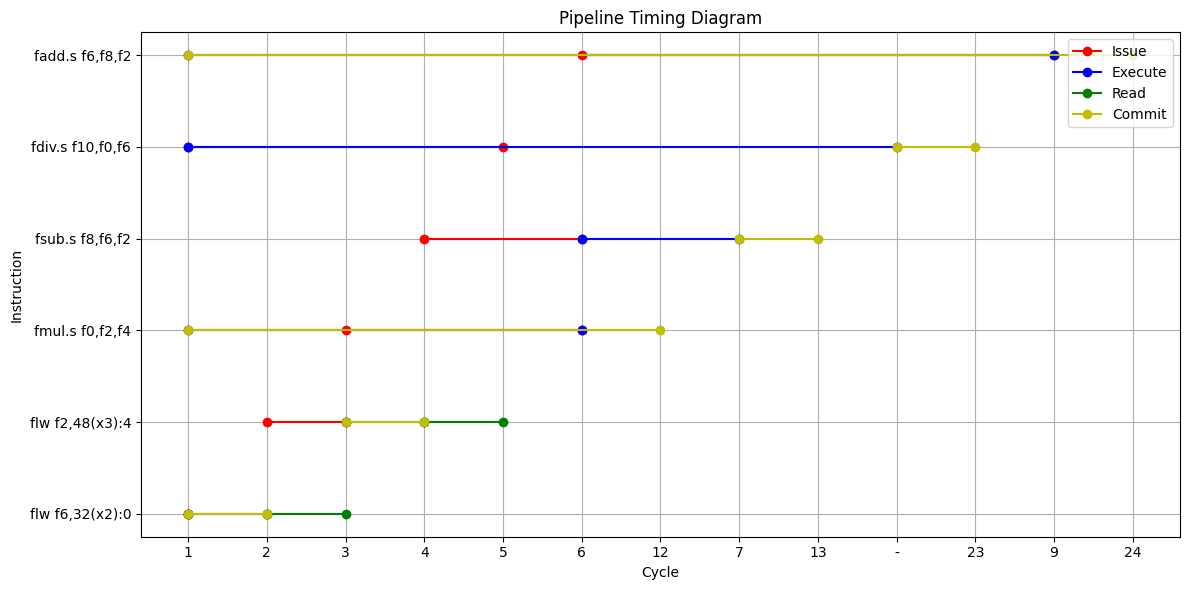

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with the extracted data from the simulation results
instructions = ['flw f6,32(x2):0', 'flw f2,48(x3):4', 'fmul.s f0,f2,f4', 'fsub.s f8,f6,f2', 'fdiv.s f10,f0,f6', 'fadd.s f6,f8,f2']
issues = [1, 2, 3, 4, 5, 6]
executes = ['1-2', '3-4', '6-10', '6-7', '12-21', '9-10']
reads = [3, 5, '-', '-', '-', '-']
results = [1, 3, 11, 8, 22, 12]
commits = [1, 3, 12, 13, 23, 24]

plt.figure(figsize=(12, 6))
plt.title("Pipeline Timing Diagram")
plt.xlabel("Cycle")
plt.ylabel("Instruction")

# Plotting the timing for each instruction
for i in range(len(instructions)):
    plt.plot([issues[i], executes[i][0]], [i, i], 'ro-')  # Issue to Execute
    plt.plot([executes[i][0], executes[i][2]], [i, i], 'bo-')  # Execute to Read
    if reads[i] != '-':
        plt.plot([executes[i][2], reads[i]], [i, i], 'go-')  # Read to Result
    plt.plot([executes[i][2], commits[i]], [i, i], 'yo-')  # Read to Commit

# Set yticks labels as instruction names
plt.yticks(range(len(instructions)), instructions)

# Adding legend for each stage
plt.legend(['Issue', 'Execute', 'Read', 'Commit'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()
